In [1]:
import os
import numpy as np
import librosa
import soundfile as sf
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from pystoi import stoi
import pandas as pd

# Конфигурация
ORIGINAL_DIR = "/home/danya/datasets/CMU-MOSEI/Audio/WAV_16000/"
NOISE_DIR = "/home/danya/datasets/CMU-MOSEI/Audio/noise/"
REVERB_DIR = "/home/danya/datasets/CMU-MOSEI/Audio/reverb/"
NOISE_REVERB_DIR = "/home/danya/datasets/CMU-MOSEI/Audio/noise_reverb/"
EXTREME_STOI_DIR = "/home/danya/datasets/CMU-MOSEI/Audio/extreme_stoi/"

# Настройка стиля графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Создаем папку для сохранения графиков
IMAGES_DIR = "images"
os.makedirs(IMAGES_DIR, exist_ok=True)
print(f"Графики будут сохранены в папку: {IMAGES_DIR}")


Графики будут сохранены в папку: images


In [2]:
def parse_noise_filename(filename):
    """
    Парсит имя файла с шумом и извлекает SNR.
    Формат: snr=12_34__name=original_filename.wav
    """
    match = re.search(r'^snr=([0-9_\-]+)__', filename)
    if match:
        snr_str = match.group(1).replace('_', '.')
        try:
            return float(snr_str)
        except:
            return None
    return None

def parse_reverb_filename(filename):
    """
    Парсит имя файла с реверберацией и извлекает RT60 и wet_level.
    Формат: rt60=0_87__wet=0_5__name=original_filename.wav
    """
    rt60_match = re.search(r'^rt60=([0-9_]+)__', filename)
    wet_match = re.search(r'__wet=([0-9_]+)__', filename)
    
    rt60 = None
    wet = None
    
    if rt60_match:
        rt60_str = rt60_match.group(1).replace('_', '.')
        try:
            rt60 = float(rt60_str)
        except:
            pass
    
    if wet_match:
        wet_str = wet_match.group(1).replace('_', '.')
        try:
            wet = float(wet_str)
        except:
            pass
    
    return rt60, wet

def parse_noise_reverb_filename(filename):
    """
    Парсит имя файла с шумом и реверберацией и извлекает SNR, RT60 и wet_level.
    Формат: snr=12_34__rt60=0_87__wet=0_5__name=original_filename.wav
    """
    snr_match = re.search(r'^snr=([0-9_\-]+)__', filename)
    rt60_match = re.search(r'__rt60=([0-9_]+)__', filename)
    wet_match = re.search(r'__wet=([0-9_]+)__', filename)
    
    snr = None
    rt60 = None
    wet = None
    
    if snr_match:
        snr_str = snr_match.group(1).replace('_', '.')
        try:
            snr = float(snr_str)
        except:
            pass
    
    if rt60_match:
        rt60_str = rt60_match.group(1).replace('_', '.')
        try:
            rt60 = float(rt60_str)
        except:
            pass
    
    if wet_match:
        wet_str = wet_match.group(1).replace('_', '.')
        try:
            wet = float(wet_str)
        except:
            pass
    
    return snr, rt60, wet

def parse_extreme_stoi_filename(filename):
    """
    Парсит имя файла в extreme_stoi и извлекает целевое STOI из префикса.
    Формат: high_stoi_0.9991__snr=...__name=original.wav
            low_stoi_0.0012__rt60=...__name=original.wav
    """
    match = re.search(r'^(?:high|low)_stoi_([0-9_\.]+)', filename)
    if match:
        stoi_str = match.group(1).replace('_', '.')
        try:
            return float(stoi_str)
        except:
            return None
    return None

def extract_original_filename(filename):
    """
    Извлекает оригинальное имя файла из конца после name=
    Формат: snr=12_34__name=original_filename.wav или rt60=0_87__wet=0_5__name=original_filename.wav
    """
    # Ищем все после последнего __name=
    match = re.search(r'__name=(.+)$', filename)
    if match:
        original_name = match.group(1)
        # Если имя уже содержит расширение, возвращаем как есть, иначе добавляем .wav
        if not original_name.endswith('.wav'):
            return original_name + '.wav'
        return original_name
    # Fallback: если формат старый, извлекаем после последнего __
    if '__' in filename:
        return filename.split('__')[-1]
    return filename

def find_original_file(original_filename, base_dir):
    """
    Находит оригинальный файл в директории (рекурсивно).
    """
    base_path = Path(base_dir)
    for wav_file in base_path.rglob(original_filename):
        return str(wav_file)
    return None

def calculate_stoi_score(processed_file, original_file):
    """
    Вычисляет STOI между обработанным и оригинальным файлом.
    """
    try:
        # Загружаем оба файла
        processed, sr_proc = librosa.load(processed_file, sr=None, mono=True)
        original, sr_orig = librosa.load(original_file, sr=None, mono=True)
        
        # Убеждаемся, что частота дискретизации одинакова
        if sr_proc != sr_orig:
            # Ресемплируем к меньшей частоте
            target_sr = min(sr_proc, sr_orig)
            if sr_proc != target_sr:
                processed = librosa.resample(processed, orig_sr=sr_proc, target_sr=target_sr)
            if sr_orig != target_sr:
                original = librosa.resample(original, orig_sr=sr_orig, target_sr=target_sr)
            sr = target_sr
        else:
            sr = sr_proc
        
        # Обрезаем до минимальной длины
        min_len = min(len(processed), len(original))
        processed = processed[:min_len]
        original = original[:min_len]
        
        # Вычисляем STOI
        stoi_score = stoi(original, processed, sr, extended=False)
        return stoi_score
    except Exception as e:
        print(f"Error calculating STOI for {processed_file}: {e}")
        return None


In [3]:
# Собираем данные о файлах с шумом (включая файлы из extreme_stoi с шумом)
print("Собираем данные о файлах с шумом...")
noise_data = []

# Обрабатываем файлы из папки noise
noise_path = Path(NOISE_DIR)
if noise_path.exists():
    noise_files = list(noise_path.rglob("*.wav"))
    print(f"Найдено {len(noise_files)} файлов с шумом в папке noise")
    
    for noise_file in tqdm(noise_files, desc="Обработка файлов с шумом"):
        filename = noise_file.name
        snr = parse_noise_filename(filename)
        
        if snr is not None:
            original_filename = extract_original_filename(filename)
            original_file = find_original_file(original_filename, ORIGINAL_DIR)
            
            if original_file:
                stoi_score = calculate_stoi_score(str(noise_file), original_file)
                noise_data.append({
                    'filename': str(noise_file),
                    'snr': snr,
                    'stoi': stoi_score,
                    'original_file': original_file
                })
            else:
                print(f"Не найден оригинальный файл для {filename}")
        else:
            print(f"Не удалось распарсить SNR из {filename}")
else:
    print(f"Директория {NOISE_DIR} не существует")

# Обрабатываем файлы из extreme_stoi, которые содержат шум (имеют snr= в имени)
extreme_stoi_path = Path(EXTREME_STOI_DIR)
if extreme_stoi_path.exists():
    extreme_files = list(extreme_stoi_path.rglob("*.wav"))
    # Фильтруем только файлы с шумом (содержат snr= в имени, но не содержат rt60=)
    extreme_noise_files = [f for f in extreme_files if 'snr=' in f.name and 'rt60=' not in f.name]
    print(f"Найдено {len(extreme_noise_files)} файлов с шумом в папке extreme_stoi")
    
    for extreme_file in tqdm(extreme_noise_files, desc="Обработка файлов extreme_stoi с шумом"):
        filename = extreme_file.name
        snr = parse_noise_filename(filename)
        
        if snr is not None:
            original_filename = extract_original_filename(filename)
            original_file = find_original_file(original_filename, ORIGINAL_DIR)
            
            if original_file:
                stoi_score = calculate_stoi_score(str(extreme_file), original_file)
                noise_data.append({
                    'filename': str(extreme_file),
                    'snr': snr,
                    'stoi': stoi_score,
                    'original_file': original_file
                })
            else:
                print(f"Не найден оригинальный файл для {filename}")
        else:
            print(f"Не удалось распарсить SNR из {filename}")
else:
    print(f"Директория {EXTREME_STOI_DIR} не существует")

print(f"\nОбработано {len(noise_data)} файлов с шумом (включая extreme_stoi)")


Собираем данные о файлах с шумом...
Найдено 3842 файлов с шумом в папке noise


Обработка файлов с шумом:  12%|█▏        | 472/3842 [03:14<24:54,  2.25it/s]  

Не удалось распарсить SNR из snr=inf__name=PEBwwe0PLZ8.wav


Обработка файлов с шумом: 100%|██████████| 3842/3842 [26:37<00:00,  2.40it/s]  


Найдено 1876 файлов с шумом в папке extreme_stoi


Обработка файлов extreme_stoi с шумом: 100%|██████████| 1876/1876 [00:00<00:00, 131220.64it/s]

Не удалось распарсить SNR из high_stoi_0.9759__snr=26.75__name=x9E8yaFCX0Y.wav
Не удалось распарсить SNR из high_stoi_0.9556__snr=24.23__name=SH0OYx3fR7s.wav
Не удалось распарсить SNR из high_stoi_1.0000__snr=inf__name=QJBQIOmG1CA.wav
Не удалось распарсить SNR из high_stoi_0.9873__snr=34.65__name=lD4xtQ6NpDY.wav
Не удалось распарсить SNR из high_stoi_1.0000__snr=inf__name=7UlSX-syPeo.wav
Не удалось распарсить SNR из high_stoi_0.9999__snr=52.60__name=-lqc32Zpr7M.wav
Не удалось распарсить SNR из high_stoi_1.0000__snr=inf__name=96361.wav
Не удалось распарсить SNR из high_stoi_1.0000__snr=inf__name=jrDqduyQrfo.wav
Не удалось распарсить SNR из high_stoi_0.9997__snr=45.08__name=80566.wav
Не удалось распарсить SNR из high_stoi_0.9641__snr=25.20__name=137827.wav
Не удалось распарсить SNR из high_stoi_0.9934__snr=27.01__name=mjpCK2Edsv8.wav
Не удалось распарсить SNR из high_stoi_1.0000__snr=49.47__name=ICeSewdyf34.wav
Не удалось распарсить SNR из high_stoi_0.9578__snr=26.33__name=45186.wav
Не у

In [4]:
# Собираем данные о файлах с реверберацией (включая файлы из extreme_stoi с реверберацией)
print("Собираем данные о файлах с реверберацией...")
reverb_data = []

# Обрабатываем файлы из папки reverb
reverb_path = Path(REVERB_DIR)
if reverb_path.exists():
    reverb_files = list(reverb_path.rglob("*.wav"))
    print(f"Найдено {len(reverb_files)} файлов с реверберацией в папке reverb")
    
    for reverb_file in tqdm(reverb_files, desc="Обработка файлов с реверберацией"):
        filename = reverb_file.name
        rt60, wet = parse_reverb_filename(filename)
        
        if rt60 is not None and wet is not None:
            original_filename = extract_original_filename(filename)
            original_file = find_original_file(original_filename, ORIGINAL_DIR)
            
            if original_file:
                stoi_score = calculate_stoi_score(str(reverb_file), original_file)
                reverb_data.append({
                    'filename': str(reverb_file),
                    'rt60': rt60,
                    'wet_level': wet,
                    'stoi': stoi_score,
                    'original_file': original_file
                })
            else:
                print(f"Не найден оригинальный файл для {filename}")
        else:
            print(f"Не удалось распарсить параметры из {filename}")
else:
    print(f"Директория {REVERB_DIR} не существует")

# Обрабатываем файлы из extreme_stoi, которые содержат реверберацию (имеют rt60= в имени, но не содержат snr=)
extreme_stoi_path = Path(EXTREME_STOI_DIR)
if extreme_stoi_path.exists():
    extreme_files = list(extreme_stoi_path.rglob("*.wav"))
    # Фильтруем только файлы с реверберацией (содержат rt60= в имени, но не содержат snr=)
    extreme_reverb_files = [f for f in extreme_files if 'rt60=' in f.name and 'snr=' not in f.name]
    print(f"Найдено {len(extreme_reverb_files)} файлов с реверберацией в папке extreme_stoi")
    
    for extreme_file in tqdm(extreme_reverb_files, desc="Обработка файлов extreme_stoi с реверберацией"):
        filename = extreme_file.name
        rt60, wet = parse_reverb_filename(filename)
        
        if rt60 is not None and wet is not None:
            original_filename = extract_original_filename(filename)
            original_file = find_original_file(original_filename, ORIGINAL_DIR)
            
            if original_file:
                stoi_score = calculate_stoi_score(str(extreme_file), original_file)
                reverb_data.append({
                    'filename': str(extreme_file),
                    'rt60': rt60,
                    'wet_level': wet,
                    'stoi': stoi_score,
                    'original_file': original_file
                })
            else:
                print(f"Не найден оригинальный файл для {filename}")
        else:
            print(f"Не удалось распарсить параметры из {filename}")
else:
    print(f"Директория {EXTREME_STOI_DIR} не существует")

print(f"\nОбработано {len(reverb_data)} файлов с реверберацией (включая extreme_stoi)")


Собираем данные о файлах с реверберацией...
Найдено 3842 файлов с реверберацией в папке reverb


Обработка файлов с реверберацией:   0%|          | 0/3842 [00:00<?, ?it/s]

Обработка файлов с реверберацией: 100%|██████████| 3842/3842 [26:16<00:00,  2.44it/s]  


Найдено 2000 файлов с реверберацией в папке extreme_stoi


Обработка файлов extreme_stoi с реверберацией: 100%|██████████| 2000/2000 [00:00<00:00, 162148.84it/s]

Не удалось распарсить параметры из low_stoi_0.0056__rt60=4_39__wet=0_94__name=dDFyJp_OkeA.wav
Не удалось распарсить параметры из low_stoi_0.0221__rt60=3_44__wet=0_83__name=19850.wav
Не удалось распарсить параметры из low_stoi_0.0770__rt60=3_00__wet=0_87__name=oNnoN0bxVnA.wav
Не удалось распарсить параметры из low_stoi_0.0193__rt60=3_74__wet=0_94__name=w-PFjo89Dpw.wav
Не удалось распарсить параметры из low_stoi_0.0472__rt60=2_91__wet=0_88__name=206507.wav
Не удалось распарсить параметры из low_stoi_0.0854__rt60=3_05__wet=0_89__name=L3b9wwZ8vRQ.wav
Не удалось распарсить параметры из low_stoi_0.0418__rt60=3_98__wet=0_95__name=22689.wav
Не удалось распарсить параметры из low_stoi_0.1216__rt60=3_27__wet=0_95__name=69234.wav
Не удалось распарсить параметры из low_stoi_0.2023__rt60=2_72__wet=0_90__name=0eTibWQdO5M.wav
Не удалось распарсить параметры из low_stoi_0.1739__rt60=3_44__wet=0_86__name=ZMAoUt0SD7E.wav
Не удалось распарсить параметры из low_stoi_0.0654__rt60=3_80__wet=0_91__name=a7HHg

In [5]:
# Собираем данные о файлах с шумом и реверберацией
print("Собираем данные о файлах с шумом и реверберацией...")
noise_reverb_data = []

noise_reverb_path = Path(NOISE_REVERB_DIR)
if noise_reverb_path.exists():
    noise_reverb_files = list(noise_reverb_path.rglob("*.wav"))
    print(f"Найдено {len(noise_reverb_files)} файлов с шумом и реверберацией")
    
    for noise_reverb_file in tqdm(noise_reverb_files, desc="Обработка файлов с шумом и реверберацией"):
        filename = noise_reverb_file.name
        snr, rt60, wet = parse_noise_reverb_filename(filename)
        
        if snr is not None and rt60 is not None and wet is not None:
            original_filename = extract_original_filename(filename)
            original_file = find_original_file(original_filename, ORIGINAL_DIR)
            
            if original_file:
                stoi_score = calculate_stoi_score(str(noise_reverb_file), original_file)
                noise_reverb_data.append({
                    'filename': str(noise_reverb_file),
                    'snr': snr,
                    'rt60': rt60,
                    'wet_level': wet,
                    'stoi': stoi_score,
                    'original_file': original_file
                })
            else:
                print(f"Не найден оригинальный файл для {filename}")
        else:
            print(f"Не удалось распарсить параметры из {filename}")
else:
    print(f"Директория {NOISE_REVERB_DIR} не существует")

print(f"\nОбработано {len(noise_reverb_data)} файлов с шумом и реверберацией")


Собираем данные о файлах с шумом и реверберацией...
Найдено 3842 файлов с шумом и реверберацией


Обработка файлов с шумом и реверберацией: 100%|██████████| 3842/3842 [25:47<00:00,  2.48it/s]  


Обработано 3842 файлов с шумом и реверберацией


In [6]:
# Собираем данные о файлах с экстремальными значениями STOI
print("Собираем данные о файлах с экстремальными значениями STOI...")
extreme_stoi_data = []

extreme_path = Path(EXTREME_STOI_DIR)
if extreme_path.exists():
    extreme_files = list(extreme_path.rglob("*.wav"))
    print(f"Найдено {len(extreme_files)} файлов в extreme_stoi")
    
    for extreme_file in tqdm(extreme_files, desc="Обработка файлов extreme_stoi"):
        filename = extreme_file.name
        target_stoi = parse_extreme_stoi_filename(filename)
        
        original_filename = extract_original_filename(filename)
        original_file = find_original_file(original_filename, ORIGINAL_DIR)
        
        if original_file:
            stoi_score = calculate_stoi_score(str(extreme_file), original_file)
            extreme_stoi_data.append({
                'filename': str(extreme_file),
                'target_stoi': target_stoi,
                'stoi': stoi_score,
                'original_file': original_file
            })
        else:
            print(f"Не найден оригинальный файл для {filename}")
else:
    print(f"Директория {EXTREME_STOI_DIR} не существует")

print(f"\nОбработано {len(extreme_stoi_data)} файлов extreme_stoi")


Собираем данные о файлах с экстремальными значениями STOI...
Найдено 3876 файлов в extreme_stoi


Обработка файлов extreme_stoi:   0%|          | 0/3876 [00:00<?, ?it/s]

Обработка файлов extreme_stoi: 100%|██████████| 3876/3876 [26:37<00:00,  2.43it/s]  


Обработано 3876 файлов extreme_stoi


In [7]:
# Создаем DataFrame для удобства работы
df_noise = pd.DataFrame(noise_data)
df_reverb = pd.DataFrame(reverb_data)
df_noise_reverb = pd.DataFrame(noise_reverb_data)
df_extreme = pd.DataFrame(extreme_stoi_data)

# Фильтруем записи с валидным STOI
df_noise = df_noise[df_noise['stoi'].notna()]
df_reverb = df_reverb[df_reverb['stoi'].notna()]
df_noise_reverb = df_noise_reverb[df_noise_reverb['stoi'].notna()]
df_extreme = df_extreme[df_extreme['stoi'].notna()]

print(f"\nСтатистика по файлам с шумом:")
print(f"  Всего файлов: {len(df_noise)}")
if len(df_noise) > 0:
    print(f"  SNR: min={df_noise['snr'].min():.2f}, max={df_noise['snr'].max():.2f}, mean={df_noise['snr'].mean():.2f}")
    print(f"  STOI: min={df_noise['stoi'].min():.3f}, max={df_noise['stoi'].max():.3f}, mean={df_noise['stoi'].mean():.3f}")

print(f"\nСтатистика по файлам с реверберацией:")
print(f"  Всего файлов: {len(df_reverb)}")
if len(df_reverb) > 0:
    print(f"  RT60: min={df_reverb['rt60'].min():.2f}, max={df_reverb['rt60'].max():.2f}, mean={df_reverb['rt60'].mean():.2f}")
    print(f"  Wet level: min={df_reverb['wet_level'].min():.2f}, max={df_reverb['wet_level'].max():.2f}, mean={df_reverb['wet_level'].mean():.2f}")
    print(f"  STOI: min={df_reverb['stoi'].min():.3f}, max={df_reverb['stoi'].max():.3f}, mean={df_reverb['stoi'].mean():.3f}")

print(f"\nСтатистика по файлам с шумом и реверберацией:")
print(f"  Всего файлов: {len(df_noise_reverb)}")
if len(df_noise_reverb) > 0:
    print(f"  SNR: min={df_noise_reverb['snr'].min():.2f}, max={df_noise_reverb['snr'].max():.2f}, mean={df_noise_reverb['snr'].mean():.2f}")
    print(f"  RT60: min={df_noise_reverb['rt60'].min():.2f}, max={df_noise_reverb['rt60'].max():.2f}, mean={df_noise_reverb['rt60'].mean():.2f}")
    print(f"  Wet level: min={df_noise_reverb['wet_level'].min():.2f}, max={df_noise_reverb['wet_level'].max():.2f}, mean={df_noise_reverb['wet_level'].mean():.2f}")
    print(f"  STOI: min={df_noise_reverb['stoi'].min():.3f}, max={df_noise_reverb['stoi'].max():.3f}, mean={df_noise_reverb['stoi'].mean():.3f}")

print(f"\nСтатистика по файлам extreme_stoi:")
print(f"  Всего файлов: {len(df_extreme)}")
if len(df_extreme) > 0:
    if 'target_stoi' in df_extreme.columns and df_extreme['target_stoi'].notna().any():
        print(f"  Target STOI: min={df_extreme['target_stoi'].min():.3f}, max={df_extreme['target_stoi'].max():.3f}, mean={df_extreme['target_stoi'].mean():.3f}")
    print(f"  STOI: min={df_extreme['stoi'].min():.3f}, max={df_extreme['stoi'].max():.3f}, mean={df_extreme['stoi'].mean():.3f}")

# Общая статистика по всему датасету
if len(df_extreme) > 0:
    df_all = pd.concat([df_noise, df_reverb, df_noise_reverb, df_extreme], ignore_index=True)
else:
    df_all = pd.concat([df_noise, df_reverb, df_noise_reverb], ignore_index=True)

print(f"\nОбщая статистика по всему датасету:")
print(f"  Всего файлов: {len(df_all)}")
if len(df_all) > 0:
    print(f"  STOI: min={df_all['stoi'].min():.3f}, max={df_all['stoi'].max():.3f}, mean={df_all['stoi'].mean():.3f}")



Статистика по файлам с шумом:
  Всего файлов: 3841
  SNR: min=-9.96, max=19.98, mean=5.00
  STOI: min=0.114, max=0.986, mean=0.653

Статистика по файлам с реверберацией:
  Всего файлов: 3842
  RT60: min=0.10, max=2.00, mean=1.05
  Wet level: min=0.10, max=0.80, mean=0.45
  STOI: min=-0.080, max=0.927, mean=0.260

Статистика по файлам с шумом и реверберацией:
  Всего файлов: 3842
  SNR: min=-10.00, max=19.99, mean=5.00
  RT60: min=0.10, max=2.00, mean=1.05
  Wet level: min=0.10, max=0.80, mean=0.45
  STOI: min=-0.076, max=0.858, mean=0.224

Статистика по файлам extreme_stoi:
  Всего файлов: 3876
  STOI: min=0.000, max=1.000, mean=0.530

Общая статистика по всему датасету:
  Всего файлов: 15401
  STOI: min=-0.080, max=1.000, mean=0.417


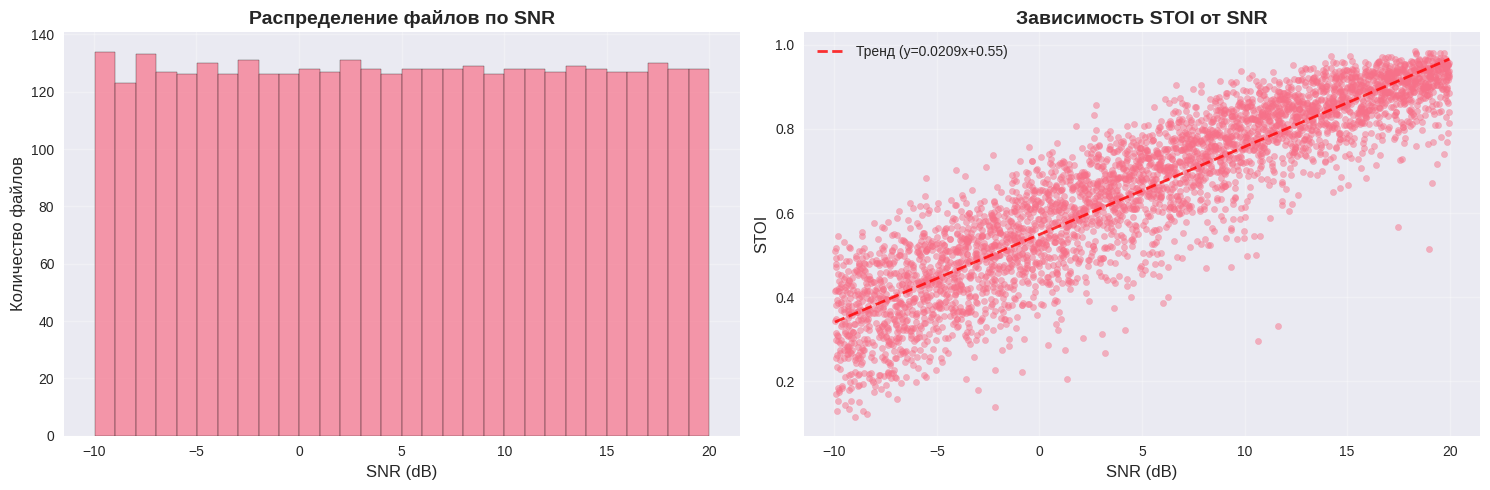

In [8]:
# График 1: Распределение по SNR
if len(df_noise) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Гистограмма SNR
    axes[0].hist(df_noise['snr'], bins=30, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('SNR (dB)', fontsize=12)
    axes[0].set_ylabel('Количество файлов', fontsize=12)
    axes[0].set_title('Распределение файлов по SNR', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Зависимость STOI от SNR
    axes[1].scatter(df_noise['snr'], df_noise['stoi'], alpha=0.5, s=20)
    axes[1].set_xlabel('SNR (dB)', fontsize=12)
    axes[1].set_ylabel('STOI', fontsize=12)
    axes[1].set_title('Зависимость STOI от SNR', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # Добавляем линию тренда
    if len(df_noise) > 1:
        z = np.polyfit(df_noise['snr'], df_noise['stoi'], 1)
        p = np.poly1d(z)
        axes[1].plot(df_noise['snr'].sort_values(), p(df_noise['snr'].sort_values()), 
                    "r--", alpha=0.8, linewidth=2, label=f'Тренд (y={z[0]:.4f}x+{z[1]:.2f})')
        axes[1].legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных о файлах с шумом для построения графиков")


График сохранен: images/stoi_distribution.png


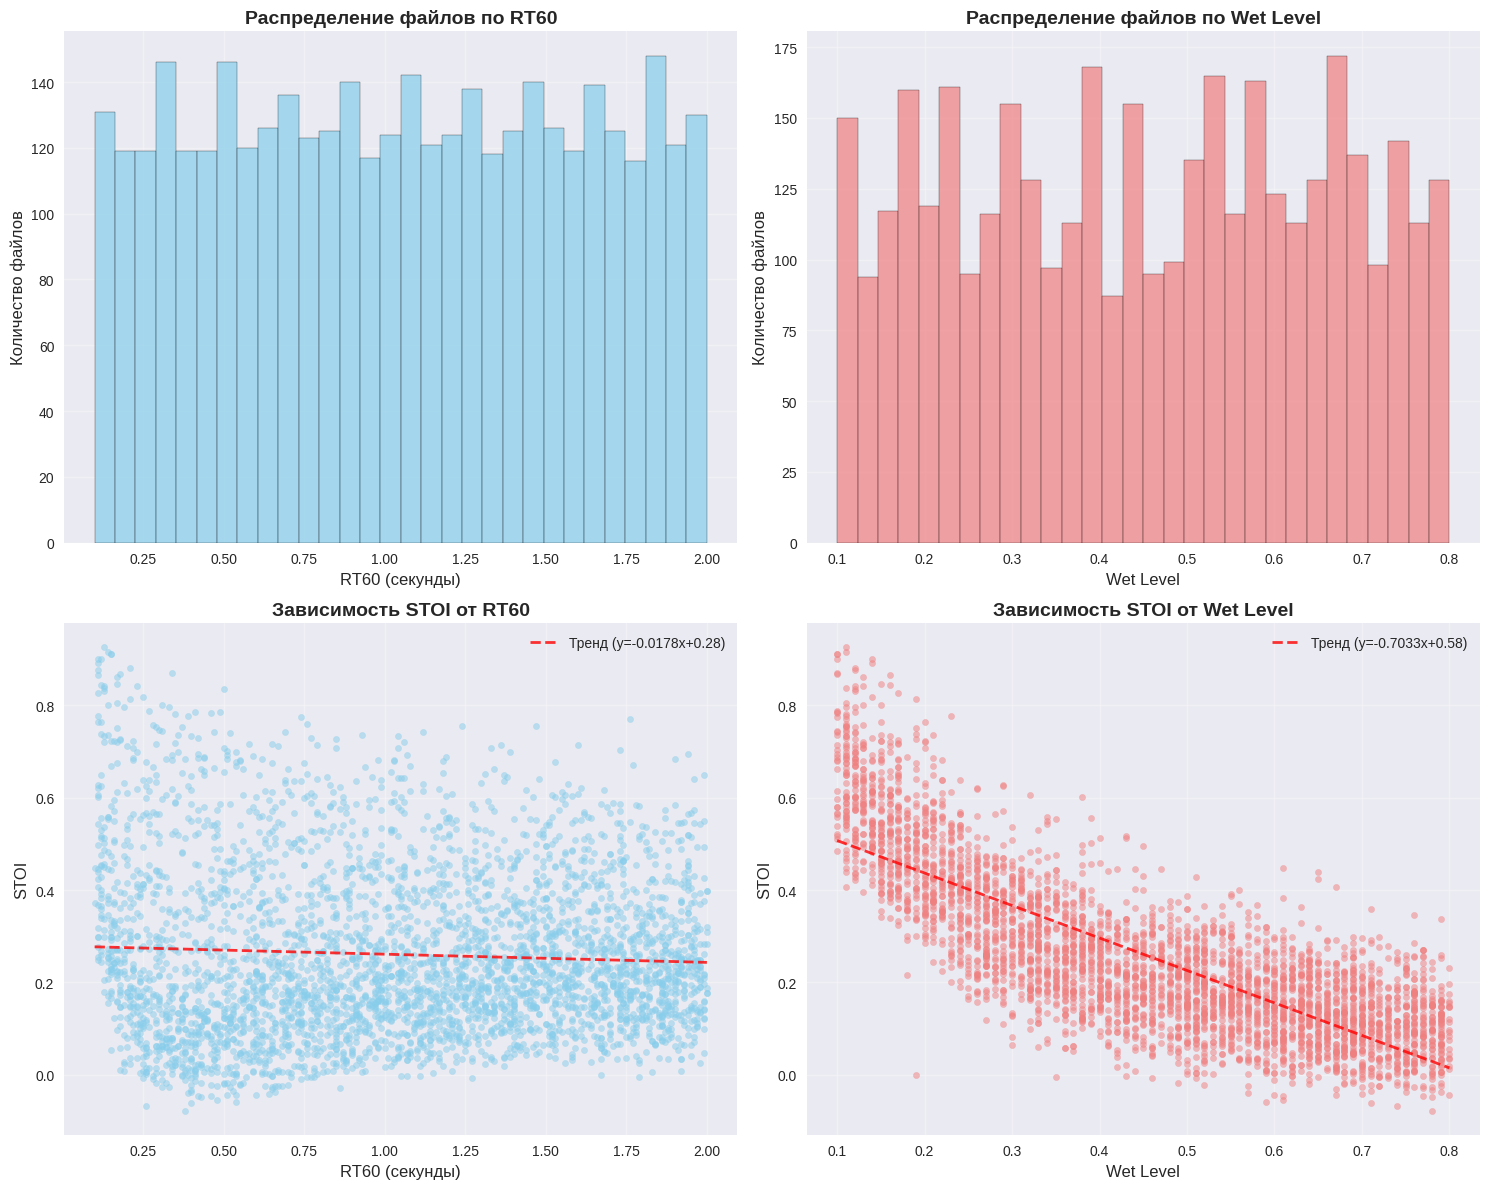

In [9]:
# График 2: Распределение по реверберации (RT60 и wet_level)
if len(df_reverb) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Гистограмма RT60
    axes[0, 0].hist(df_reverb['rt60'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0, 0].set_xlabel('RT60 (секунды)', fontsize=12)
    axes[0, 0].set_ylabel('Количество файлов', fontsize=12)
    axes[0, 0].set_title('Распределение файлов по RT60', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Гистограмма wet_level
    axes[0, 1].hist(df_reverb['wet_level'], bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
    axes[0, 1].set_xlabel('Wet Level', fontsize=12)
    axes[0, 1].set_ylabel('Количество файлов', fontsize=12)
    axes[0, 1].set_title('Распределение файлов по Wet Level', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Зависимость STOI от RT60
    axes[1, 0].scatter(df_reverb['rt60'], df_reverb['stoi'], alpha=0.5, s=20, color='skyblue')
    axes[1, 0].set_xlabel('RT60 (секунды)', fontsize=12)
    axes[1, 0].set_ylabel('STOI', fontsize=12)
    axes[1, 0].set_title('Зависимость STOI от RT60', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Линия тренда для RT60
    if len(df_reverb) > 1:
        z = np.polyfit(df_reverb['rt60'], df_reverb['stoi'], 1)
        p = np.poly1d(z)
        axes[1, 0].plot(df_reverb['rt60'].sort_values(), p(df_reverb['rt60'].sort_values()), 
                       "r--", alpha=0.8, linewidth=2, label=f'Тренд (y={z[0]:.4f}x+{z[1]:.2f})')
        axes[1, 0].legend()
    
    # Зависимость STOI от wet_level
    axes[1, 1].scatter(df_reverb['wet_level'], df_reverb['stoi'], alpha=0.5, s=20, color='lightcoral')
    axes[1, 1].set_xlabel('Wet Level', fontsize=12)
    axes[1, 1].set_ylabel('STOI', fontsize=12)
    axes[1, 1].set_title('Зависимость STOI от Wet Level', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Линия тренда для wet_level
    if len(df_reverb) > 1:
        z = np.polyfit(df_reverb['wet_level'], df_reverb['stoi'], 1)
        p = np.poly1d(z)
        axes[1, 1].plot(df_reverb['wet_level'].sort_values(), p(df_reverb['wet_level'].sort_values()), 
                       "r--", alpha=0.8, linewidth=2, label=f'Тренд (y={z[0]:.4f}x+{z[1]:.2f})')
        axes[1, 1].legend()
    
    plt.tight_layout()
# Сохраняем график
save_path = os.path.join(IMAGES_DIR, "stoi_distribution.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"График сохранен: {save_path}")
plt.show()



График сохранен: images/noise_reverb_distribution.png


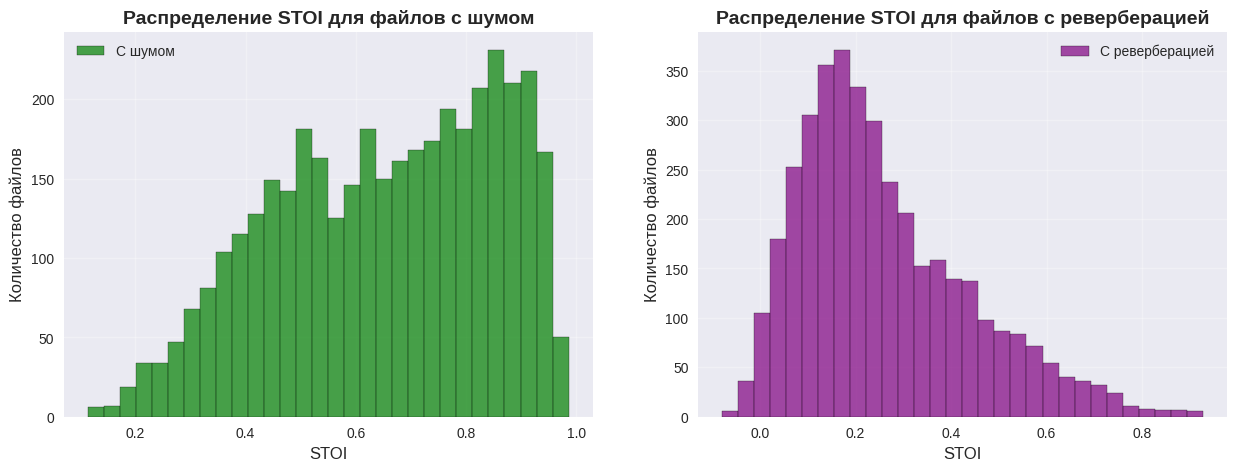

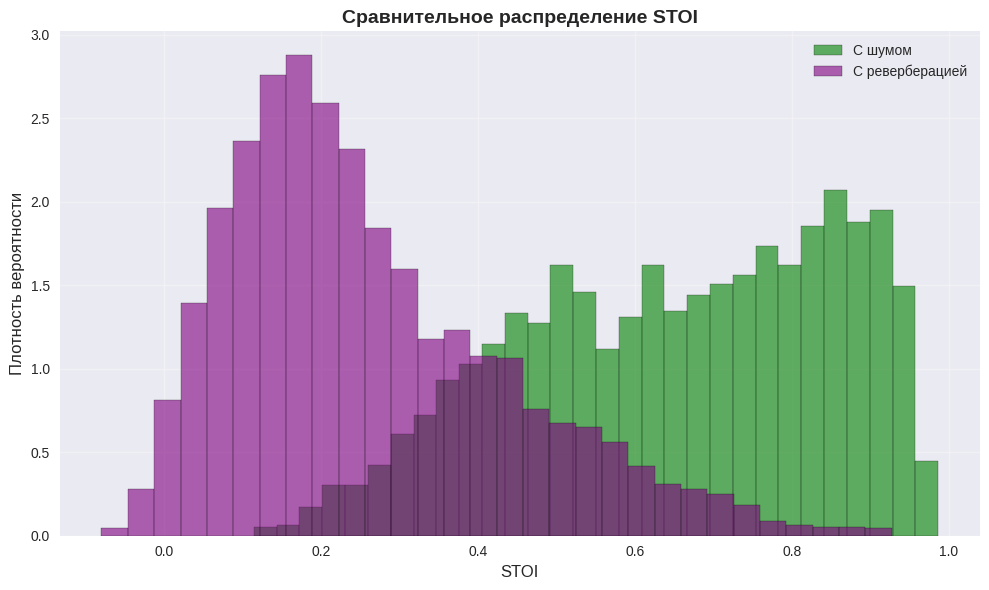

In [10]:
# График 3: Распределение по STOI
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Гистограмма STOI для файлов с шумом
if len(df_noise) > 0:
    axes[0].hist(df_noise['stoi'], bins=30, edgecolor='black', alpha=0.7, color='green', label='С шумом')
    axes[0].set_xlabel('STOI', fontsize=12)
    axes[0].set_ylabel('Количество файлов', fontsize=12)
    axes[0].set_title('Распределение STOI для файлов с шумом', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
else:
    axes[0].text(0.5, 0.5, 'Нет данных', ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title('Распределение STOI для файлов с шумом', fontsize=14, fontweight='bold')

# Гистограмма STOI для файлов с реверберацией
if len(df_reverb) > 0:
    axes[1].hist(df_reverb['stoi'], bins=30, edgecolor='black', alpha=0.7, color='purple', label='С реверберацией')
    axes[1].set_xlabel('STOI', fontsize=12)
    axes[1].set_ylabel('Количество файлов', fontsize=12)
    axes[1].set_title('Распределение STOI для файлов с реверберацией', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
else:
    axes[1].text(0.5, 0.5, 'Нет данных', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Распределение STOI для файлов с реверберацией', fontsize=14, fontweight='bold')

    plt.tight_layout()
    # Сохраняем график
    save_path = os.path.join(IMAGES_DIR, "noise_reverb_distribution.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"График сохранен: {save_path}")
    plt.show()

# Сравнительный график STOI
if len(df_noise) > 0 and len(df_reverb) > 0:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.hist(df_noise['stoi'], bins=30, edgecolor='black', alpha=0.6, color='green', label='С шумом', density=True)
    ax.hist(df_reverb['stoi'], bins=30, edgecolor='black', alpha=0.6, color='purple', label='С реверберацией', density=True)
    ax.set_xlabel('STOI', fontsize=12)
    ax.set_ylabel('Плотность вероятности', fontsize=12)
    ax.set_title('Сравнительное распределение STOI', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    # Сохраняем график
    save_path = os.path.join(IMAGES_DIR, "noise_reverb_distribution.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"График сохранен: {save_path}")
    plt.show()


График сохранен: images/reverb_3d_visualization.png


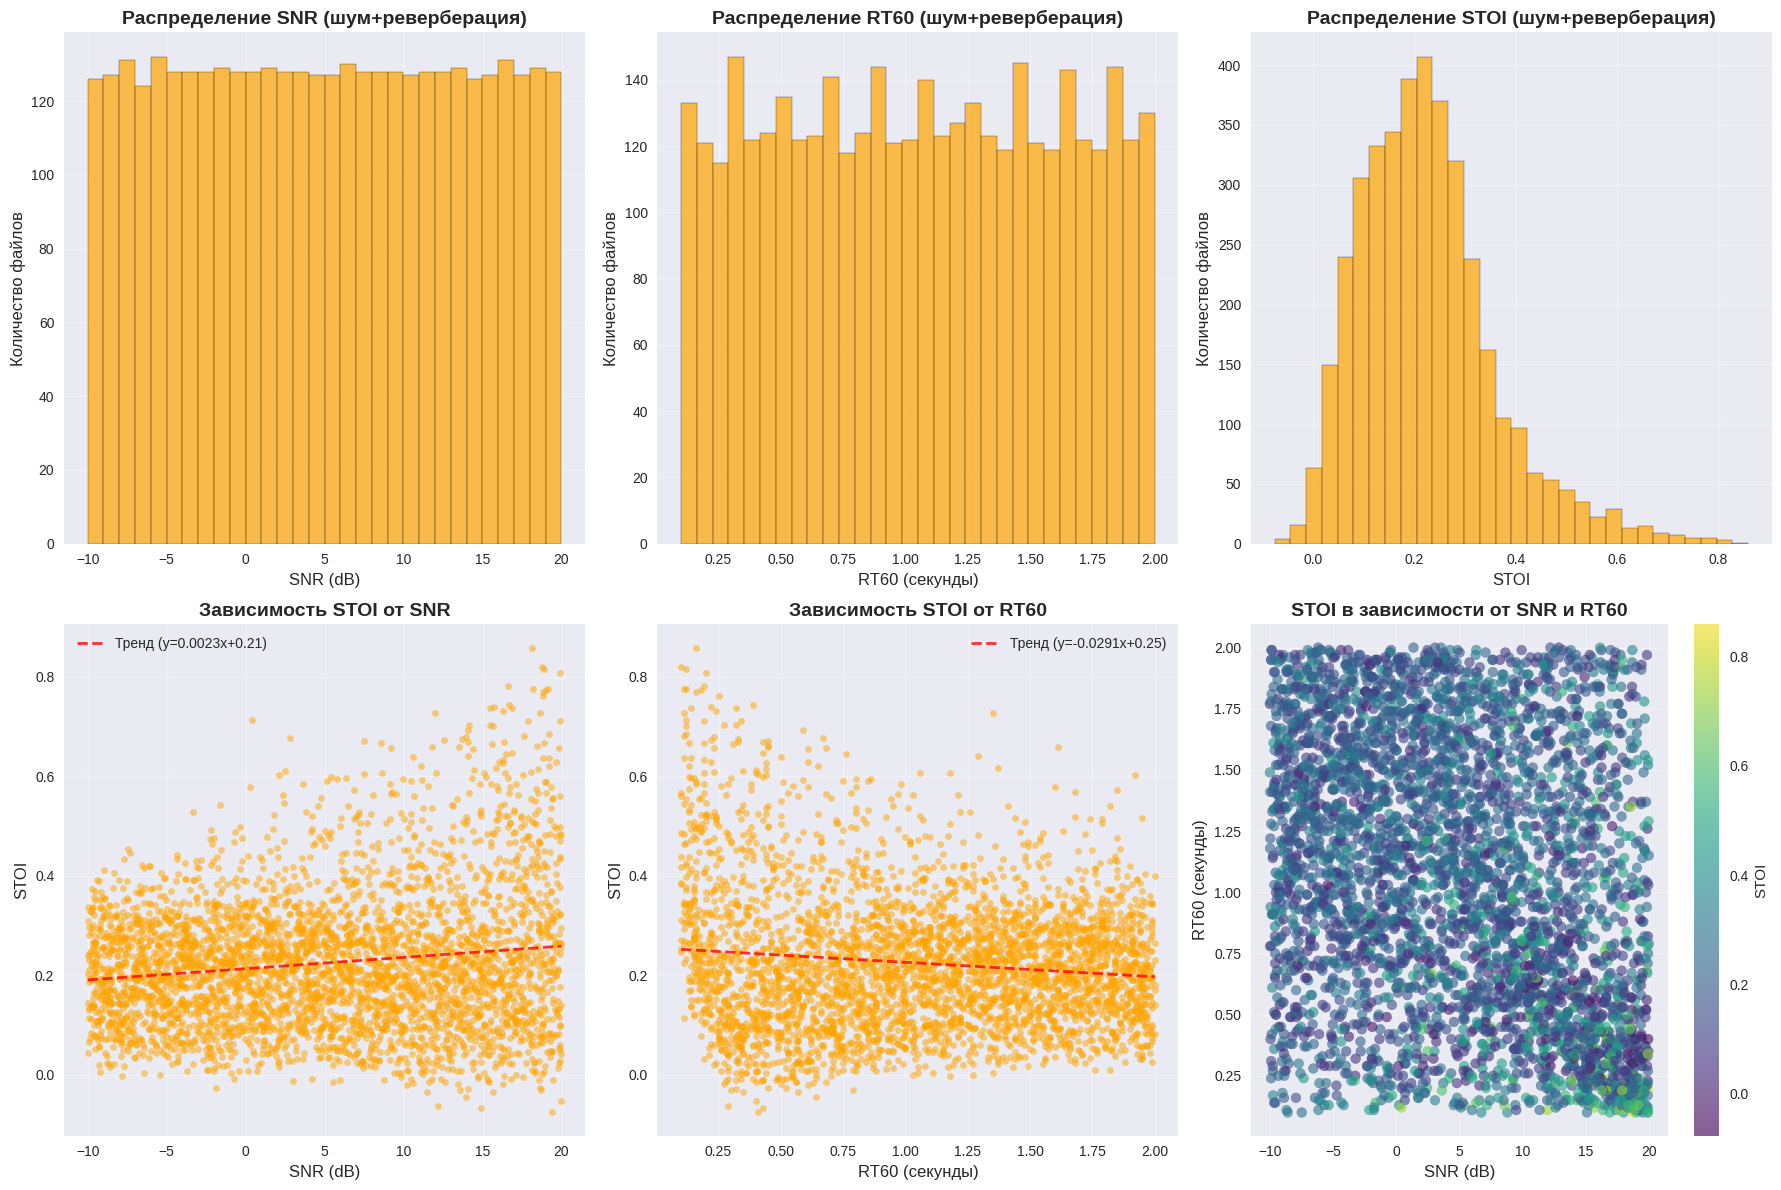

In [11]:
# График 5: Анализ файлов с шумом и реверберацией
if len(df_noise_reverb) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Гистограмма SNR
    axes[0, 0].hist(df_noise_reverb['snr'], bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 0].set_xlabel('SNR (dB)', fontsize=12)
    axes[0, 0].set_ylabel('Количество файлов', fontsize=12)
    axes[0, 0].set_title('Распределение SNR (шум+реверберация)', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Гистограмма RT60
    axes[0, 1].hist(df_noise_reverb['rt60'], bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].set_xlabel('RT60 (секунды)', fontsize=12)
    axes[0, 1].set_ylabel('Количество файлов', fontsize=12)
    axes[0, 1].set_title('Распределение RT60 (шум+реверберация)', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Гистограмма STOI
    axes[0, 2].hist(df_noise_reverb['stoi'], bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 2].set_xlabel('STOI', fontsize=12)
    axes[0, 2].set_ylabel('Количество файлов', fontsize=12)
    axes[0, 2].set_title('Распределение STOI (шум+реверберация)', fontsize=14, fontweight='bold')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Зависимость STOI от SNR
    axes[1, 0].scatter(df_noise_reverb['snr'], df_noise_reverb['stoi'], alpha=0.5, s=20, color='orange')
    axes[1, 0].set_xlabel('SNR (dB)', fontsize=12)
    axes[1, 0].set_ylabel('STOI', fontsize=12)
    axes[1, 0].set_title('Зависимость STOI от SNR', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    if len(df_noise_reverb) > 1:
        z = np.polyfit(df_noise_reverb['snr'], df_noise_reverb['stoi'], 1)
        p = np.poly1d(z)
        axes[1, 0].plot(df_noise_reverb['snr'].sort_values(), p(df_noise_reverb['snr'].sort_values()), 
                       "r--", alpha=0.8, linewidth=2, label=f'Тренд (y={z[0]:.4f}x+{z[1]:.2f})')
        axes[1, 0].legend()
    
    # Зависимость STOI от RT60
    axes[1, 1].scatter(df_noise_reverb['rt60'], df_noise_reverb['stoi'], alpha=0.5, s=20, color='orange')
    axes[1, 1].set_xlabel('RT60 (секунды)', fontsize=12)
    axes[1, 1].set_ylabel('STOI', fontsize=12)
    axes[1, 1].set_title('Зависимость STOI от RT60', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    if len(df_noise_reverb) > 1:
        z = np.polyfit(df_noise_reverb['rt60'], df_noise_reverb['stoi'], 1)
        p = np.poly1d(z)
        axes[1, 1].plot(df_noise_reverb['rt60'].sort_values(), p(df_noise_reverb['rt60'].sort_values()), 
                       "r--", alpha=0.8, linewidth=2, label=f'Тренд (y={z[0]:.4f}x+{z[1]:.2f})')
        axes[1, 1].legend()
    
    # 2D scatter plot с цветовой кодировкой по STOI
    scatter = axes[1, 2].scatter(df_noise_reverb['snr'], df_noise_reverb['rt60'], 
                                c=df_noise_reverb['stoi'], cmap='viridis', s=50, alpha=0.6)
    axes[1, 2].set_xlabel('SNR (dB)', fontsize=12)
    axes[1, 2].set_ylabel('RT60 (секунды)', fontsize=12)
    axes[1, 2].set_title('STOI в зависимости от SNR и RT60', fontsize=14, fontweight='bold')
    plt.colorbar(scatter, ax=axes[1, 2], label='STOI')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    # Сохраняем график
    save_path = os.path.join(IMAGES_DIR, "reverb_3d_visualization.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"График сохранен: {save_path}")
    plt.show()
else:
    print("Нет данных о файлах с шумом и реверберацией для построения графиков")


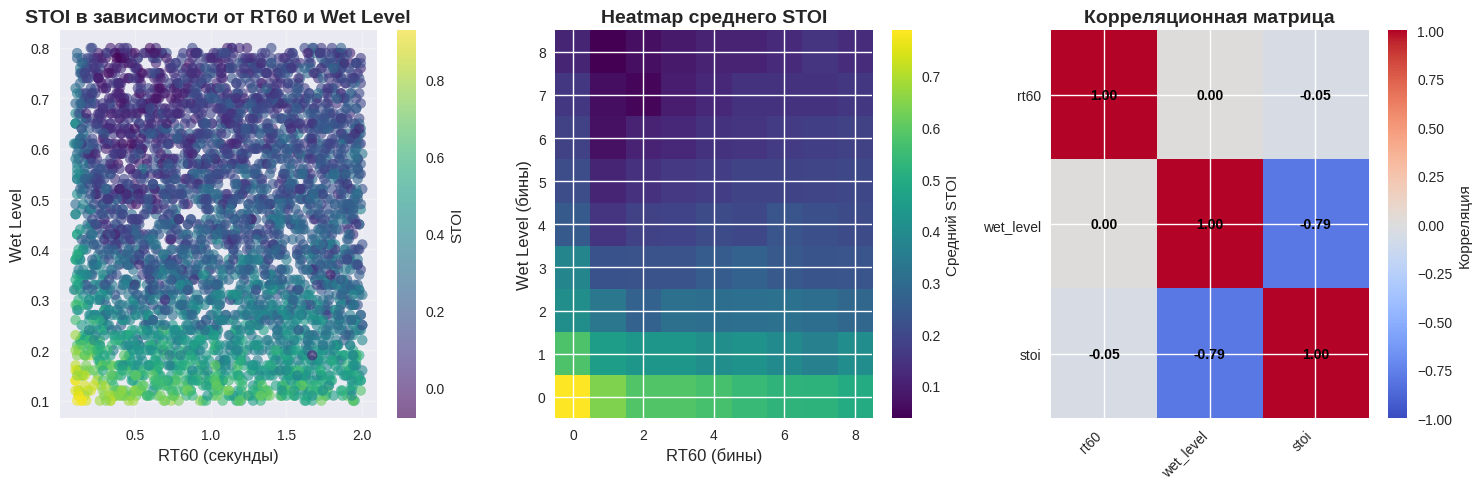

In [12]:
# График 4: 3D визуализация зависимости STOI от RT60 и wet_level
if len(df_reverb) > 0:
    fig = plt.figure(figsize=(15, 5))
    
    # 2D scatter plot с цветовой кодировкой по STOI
    ax1 = fig.add_subplot(131)
    scatter = ax1.scatter(df_reverb['rt60'], df_reverb['wet_level'], 
                         c=df_reverb['stoi'], cmap='viridis', s=50, alpha=0.6)
    ax1.set_xlabel('RT60 (секунды)', fontsize=12)
    ax1.set_ylabel('Wet Level', fontsize=12)
    ax1.set_title('STOI в зависимости от RT60 и Wet Level', fontsize=14, fontweight='bold')
    plt.colorbar(scatter, ax=ax1, label='STOI')
    ax1.grid(True, alpha=0.3)
    
    # Heatmap STOI по RT60 и wet_level
    ax2 = fig.add_subplot(132)
    # Создаем бины для heatmap
    rt60_bins = np.linspace(df_reverb['rt60'].min(), df_reverb['rt60'].max(), 10)
    wet_bins = np.linspace(df_reverb['wet_level'].min(), df_reverb['wet_level'].max(), 10)
    
    # Вычисляем средний STOI для каждого бина
    heatmap_data = np.zeros((len(wet_bins)-1, len(rt60_bins)-1))
    for i in range(len(wet_bins)-1):
        for j in range(len(rt60_bins)-1):
            mask = (df_reverb['wet_level'] >= wet_bins[i]) & (df_reverb['wet_level'] < wet_bins[i+1]) & \
                   (df_reverb['rt60'] >= rt60_bins[j]) & (df_reverb['rt60'] < rt60_bins[j+1])
            if mask.sum() > 0:
                heatmap_data[i, j] = df_reverb[mask]['stoi'].mean()
            else:
                heatmap_data[i, j] = np.nan
    
    im = ax2.imshow(heatmap_data, aspect='auto', origin='lower', cmap='viridis', interpolation='nearest')
    ax2.set_xlabel('RT60 (бины)', fontsize=12)
    ax2.set_ylabel('Wet Level (бины)', fontsize=12)
    ax2.set_title('Heatmap среднего STOI', fontsize=14, fontweight='bold')
    plt.colorbar(im, ax=ax2, label='Средний STOI')
    
    # Корреляционная матрица
    ax3 = fig.add_subplot(133)
    corr_data = df_reverb[['rt60', 'wet_level', 'stoi']].corr()
    im = ax3.imshow(corr_data, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    ax3.set_xticks(range(len(corr_data.columns)))
    ax3.set_yticks(range(len(corr_data.columns)))
    ax3.set_xticklabels(corr_data.columns, rotation=45, ha='right')
    ax3.set_yticklabels(corr_data.columns)
    ax3.set_title('Корреляционная матрица', fontsize=14, fontweight='bold')
    
    # Добавляем значения корреляции
    for i in range(len(corr_data.columns)):
        for j in range(len(corr_data.columns)):
            text = ax3.text(j, i, f'{corr_data.iloc[i, j]:.2f}',
                           ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im, ax=ax3, label='Корреляция')
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных о файлах с реверберацией для 3D визуализации")


In [13]:
# Итоговая статистика и сохранение данных
print("=" * 60)
print("ИТОГОВАЯ СТАТИСТИКА ДАТАСЕТА")
print("=" * 60)

if len(df_noise) > 0:
    print("\n📊 Файлы с шумом:")
    print(f"   Всего файлов: {len(df_noise)}")
    print(f"   SNR: [{df_noise['snr'].min():.2f}, {df_noise['snr'].max():.2f}] dB, среднее: {df_noise['snr'].mean():.2f} dB")
    print(f"   STOI: [{df_noise['stoi'].min():.3f}, {df_noise['stoi'].max():.3f}], среднее: {df_noise['stoi'].mean():.3f}")
    print(f"   Стандартное отклонение STOI: {df_noise['stoi'].std():.3f}")

if len(df_reverb) > 0:
    print("\n📊 Файлы с реверберацией:")
    print(f"   Всего файлов: {len(df_reverb)}")
    print(f"   RT60: [{df_reverb['rt60'].min():.2f}, {df_reverb['rt60'].max():.2f}] с, среднее: {df_reverb['rt60'].mean():.2f} с")
    print(f"   Wet Level: [{df_reverb['wet_level'].min():.2f}, {df_reverb['wet_level'].max():.2f}], среднее: {df_reverb['wet_level'].mean():.2f}")
    print(f"   STOI: [{df_reverb['stoi'].min():.3f}, {df_reverb['stoi'].max():.3f}], среднее: {df_reverb['stoi'].mean():.3f}")
    print(f"   Стандартное отклонение STOI: {df_reverb['stoi'].std():.3f}")

if len(df_noise_reverb) > 0:
    print("\n📊 Файлы с шумом и реверберацией:")
    print(f"   Всего файлов: {len(df_noise_reverb)}")
    print(f"   SNR: [{df_noise_reverb['snr'].min():.2f}, {df_noise_reverb['snr'].max():.2f}] dB, среднее: {df_noise_reverb['snr'].mean():.2f} dB")
    print(f"   RT60: [{df_noise_reverb['rt60'].min():.2f}, {df_noise_reverb['rt60'].max():.2f}] с, среднее: {df_noise_reverb['rt60'].mean():.2f} с")
    print(f"   Wet Level: [{df_noise_reverb['wet_level'].min():.2f}, {df_noise_reverb['wet_level'].max():.2f}], среднее: {df_noise_reverb['wet_level'].mean():.2f}")
    print(f"   STOI: [{df_noise_reverb['stoi'].min():.3f}, {df_noise_reverb['stoi'].max():.3f}], среднее: {df_noise_reverb['stoi'].mean():.3f}")
    print(f"   Стандартное отклонение STOI: {df_noise_reverb['stoi'].std():.3f}")

if len(df_extreme) > 0:
    print("\n📊 Файлы extreme_stoi:")
    print(f"   Всего файлов: {len(df_extreme)}")
    if 'target_stoi' in df_extreme.columns and df_extreme['target_stoi'].notna().any():
        print(f"   Target STOI: [{df_extreme['target_stoi'].min():.3f}, {df_extreme['target_stoi'].max():.3f}], среднее: {df_extreme['target_stoi'].mean():.3f}")
    print(f"   STOI: [{df_extreme['stoi'].min():.3f}, {df_extreme['stoi'].max():.3f}], среднее: {df_extreme['stoi'].mean():.3f}")
    print(f"   Стандартное отклонение STOI: {df_extreme['stoi'].std():.3f}")

if len(df_noise) > 0 and len(df_reverb) > 0:
    print("\n📊 Сравнение:")
    print(f"   Средний STOI (шум): {df_noise['stoi'].mean():.3f}")
    print(f"   Средний STOI (реверберация): {df_reverb['stoi'].mean():.3f}")
    if len(df_noise_reverb) > 0:
        print(f"   Средний STOI (шум+реверберация): {df_noise_reverb['stoi'].mean():.3f}")
    if len(df_extreme) > 0:
        print(f"   Средний STOI (extreme_stoi): {df_extreme['stoi'].mean():.3f}")
    print(f"   Разница (шум vs реверберация): {abs(df_noise['stoi'].mean() - df_reverb['stoi'].mean()):.3f}")
    if len(df_noise_reverb) > 0:
        print(f"   Разница (шум vs шум+реверберация): {abs(df_noise['stoi'].mean() - df_noise_reverb['stoi'].mean()):.3f}")
        print(f"   Разница (реверберация vs шум+реверберация): {abs(df_reverb['stoi'].mean() - df_noise_reverb['stoi'].mean()):.3f}")

if len(df_all) > 0:
    print("\n📊 Весь датасет:")
    print(f"   Всего файлов: {len(df_all)}")
    print(f"   STOI: [{df_all['stoi'].min():.3f}, {df_all['stoi'].max():.3f}], среднее: {df_all['stoi'].mean():.3f}")
    print(f"   Стандартное отклонение STOI: {df_all['stoi'].std():.3f}")

print("\n" + "=" * 60)

# Опционально: сохранить данные в CSV
# df_noise.to_csv('noise_dataset_stats.csv', index=False)
# df_reverb.to_csv('reverb_dataset_stats.csv', index=False)
# print("\nДанные сохранены в CSV файлы")


ИТОГОВАЯ СТАТИСТИКА ДАТАСЕТА

📊 Файлы с шумом:
   Всего файлов: 3841
   SNR: [-9.96, 19.98] dB, среднее: 5.00 dB
   STOI: [0.114, 0.986], среднее: 0.653
   Стандартное отклонение STOI: 0.200

📊 Файлы с реверберацией:
   Всего файлов: 3842
   RT60: [0.10, 2.00] с, среднее: 1.05 с
   Wet Level: [0.10, 0.80], среднее: 0.45
   STOI: [-0.080, 0.927], среднее: 0.260
   Стандартное отклонение STOI: 0.179

📊 Файлы с шумом и реверберацией:
   Всего файлов: 3842
   SNR: [-10.00, 19.99] dB, среднее: 5.00 dB
   RT60: [0.10, 2.00] с, среднее: 1.05 с
   Wet Level: [0.10, 0.80], среднее: 0.45
   STOI: [-0.076, 0.858], среднее: 0.224
   Стандартное отклонение STOI: 0.134

📊 Файлы extreme_stoi:
   Всего файлов: 3876
   STOI: [0.000, 1.000], среднее: 0.530
   Стандартное отклонение STOI: 0.443

📊 Сравнение:
   Средний STOI (шум): 0.653
   Средний STOI (реверберация): 0.260
   Средний STOI (шум+реверберация): 0.224
   Средний STOI (extreme_stoi): 0.530
   Разница (шум vs реверберация): 0.393
   Разница (